# **Superstore Dataset Cleaning with BigQuery**

This notebook performs SQL-based cleaning of the Global Superstore dataset hosted in BigQuery.

## **Objective**: Prepare the Global Superstore dataset for dashboard use

This will be accomplished by:
- Cleaning and standardizing text columns
- Filtering out invalid or negative values
- Checking data for NULL values
- Ensuring data types are correctly labelled
- Identifying any outliers
- Saving and Exporting as a CSV File


In [2]:
!pip install --quiet google-cloud-bigquery pandas

from google.colab import auth
from google.cloud import bigquery
auth.authenticate_user()
client = bigquery.Client(project="superstore-072625")


### **Standardizing Column Names**

To improve consistency and simplify our analysis in the future, we standardize all column names by trimming any leading/trailing whitespace, replacing spaces with underscores, and converting names to lowercase. This should improve compatibility with tools that prefer underscore_case naming.

While this could have been automated using functions like TRIM() and LOWER() in SQL, it was decided to manually rename the columns in this dataset for control as the dataset had a manageable number of fields.

### **Filter Incorrect Data**

To ensure data quality, we filter out rows where key numerical values were invalid:

WHERE Quantity >= 0 AND Sales >= 0 AND `Shipping Cost` >= 0

This removes any records where Quantity, Sales, or Shipping Cost are negative, which would not be possible in this context. Filtering these out helps ensure that the dataset reflects realistic transactions.


In [3]:
columns_clean = """
WITH cleaned_superstore_data AS (
SELECT
  Category AS category,
  City AS city,
  Country AS country,
  "Customer ID" AS customer_id,
  "Customer Name" AS customer_name,
  Discount AS discount,
  Market AS market,
  `Order Date` AS order_date,
  `Order ID` AS order_id,
  `Order Priority`AS order_priority,
  `Product ID` AS product_id,
  "Product Name" AS product_name,
  Profit AS profit,
  Quantity AS quantity,
  Region AS region,
  `Row ID` AS row_id,
  Sales AS sales,
  Segment AS segment,
  `Ship Date` AS ship_date,
  `Ship Mode` AS ship_mode,
  `Shipping Cost` AS shipping_cost,
  State AS state,
  `Sub-Category` AS sub_category,
  Year AS year,
  Market2 as market2,
  weeknum
FROM `superstore-072625.Global_Superstore_Dataset.Glocal_Superstore_Data`
WHERE Quantity >= 0 AND Sales >= 0 AND `Shipping Cost` >= 0
)

SELECT * FROM cleaned_superstore_data

"""


### **Checking For Null Values**

To ensure our data is complete, every column in the dataset will be checked for NULL values.

This query counts how many rows contain NULL values in each column and labels these counts as the CategoryName_nulls.

Running this query reveals that there are no NULL entries in the dataset, confirming its complete for analysis without needing imputation or exclusion of missing data.

In [4]:
check_for_nulls = """

SELECT
  COUNTIF(category IS NULL) AS category_nulls,
  COUNTIF(city IS NULL) AS city_nulls,
  COUNTIF(country IS NULL) AS country_nulls,
  COUNTIF(customer_id IS NULL) AS customer_id_nulls,
  COUNTIF(customer_name IS NULL) AS customer_name_nulls,
  COUNTIF(discount IS NULL) AS discount_nulls,
  COUNTIF(market IS NULL) AS market_nulls,
  COUNTIF(order_date IS NULL) AS order_date_nulls,
  COUNTIF(order_id IS NULL) AS order_id_nulls,
  COUNTIF(order_priority IS NULL) AS order_priority_nulls,
  COUNTIF(product_id IS NULL) AS product_id_nulls,
  COUNTIF(product_name IS NULL) AS product_name_nulls,
  COUNTIF(profit IS NULL) AS profit_nulls,
  COUNTIF(quantity IS NULL) AS quantity_nulls,
  COUNTIF(region IS NULL) AS region_nulls,
  COUNTIF(row_id IS NULL) AS row_id_nulls,
  COUNTIF(sales IS NULL) AS sales_nulls,
  COUNTIF(segment IS NULL) AS segment_nulls,
  COUNTIF(ship_date IS NULL) AS ship_date_nulls,
  COUNTIF(ship_mode IS NULL) AS ship_mode_nulls,
  COUNTIF(shipping_cost IS NULL) AS shipping_cost_nulls,
  COUNTIF(state IS NULL) AS state_nulls,
  COUNTIF(sub_category IS NULL) AS sub_category_nulls,
  COUNTIF(year IS NULL) AS year_nulls,
  COUNTIF(market2 IS NULL) AS market2_nulls,
  COUNTIF(weeknum IS NULL) AS weeknum_nulls
FROM cleaned_superstore_data

"""

### **Checking Data Types**

Before performing any analysis, it's important to check that all columns have the correct data types. This prevents errors during calculations or visualizations.

We paid special attention to the following columns:

discount, profit, sales,and shipping_cost should be FLOAT because they contain decimal values. Storing them as integers would result in data loss.

order_date and ship_date should be DATETIME (or DATE) because they represent timestamps that will be used for time-based calculations like shipping duration.

After validating the data types using the following query, the results confirmed that all relevant fields are stored in the correct format, so no further type conversions were necessary.

In [5]:
check_data_types = """
SELECT
  column_name,
  data_type
FROM
  `superstore-072625.Global_Superstore_Dataset.INFORMATION_SCHEMA.COLUMNS`
WHERE
  table_name = 'cleaned_superstore_data'
ORDER BY ordinal_position;

"""

### **Checking For Outliers**

An inspection of the data to identify outliers is important to maintain the integrity of the dataset as outliers can distort calculations and impact forecasting or modeling.

In retail datasets like this one, large outliers in fields such as Sales, Profit, or Shipping Cost may be the result of bulk orders, data entry errors, or special cases like orders with especially high shipping costs or very high discounts.

A histogram was created to inspect the distribution of sales values. As expected in retail datasets, the distribution is heavily skewed — with a large number of low-value sales and a few very large ones.

Although these values are extreme, they were left in the dataset, as they likely represent valid situations rather than errors. Removing these rows of data could ultimately eliminate important insights about customer transactions.

✅ Loaded 51290 rows.


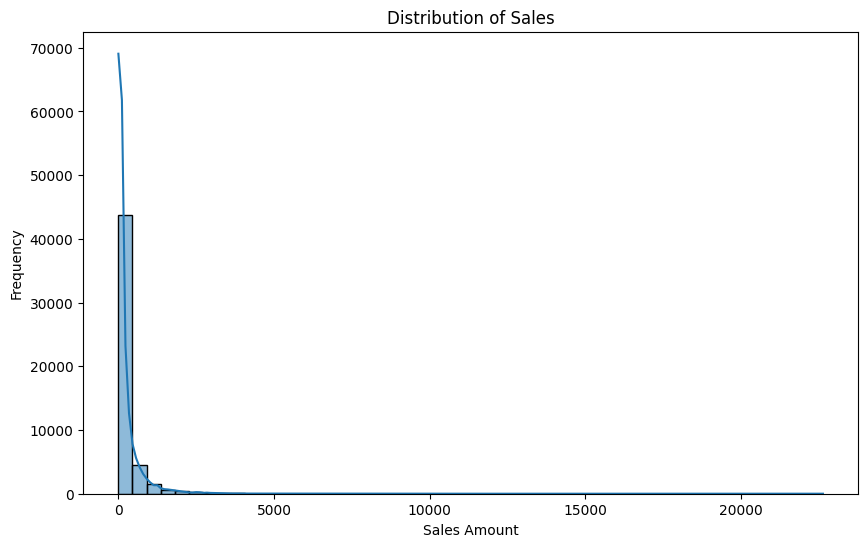

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

outlier_data = client.query(columns_clean).to_dataframe()
print(f"✅ Loaded {len(outlier_data)} rows.")

plt.figure(figsize=(10, 6))
sns.histplot(outlier_data['sales'], bins=50, kde=True)
plt.title('Distribution of Sales')
plt.xlabel('Sales Amount')
plt.ylabel('Frequency')
plt.show()



### **Adding Features**

Before exporting the data for analysis or use in a dashboard, it's important to include new features that provide deeper insight. These features are created by performing calculations on the existing data and can reveal trends or behaviors that are not directly available from the raw data.

In the query below, the following features will be added:

*days_to_ship*

*customer_order_count*

*net_sales*

*profit_margin*

*order_month*

*order_dayofweek*

*order_quarter*

These columns can be added to the original SQL query used to clean and rename columns by adding them to the SELECT statement as calculated fields.

In [14]:
feature_data = """
WITH cleaned_superstore_data AS (
SELECT
  Category AS category,
  City AS city,
  Country AS country,
  `Customer ID` AS customer_id,
  `Customer Name` AS customer_name,
  Discount AS discount,
  Market AS market,
  `Order Date` AS order_date,
  `Order ID` AS order_id,
  `Order Priority`AS order_priority,
  `Product ID` AS product_id,
  `Product Name` AS product_name,
  Profit AS profit,
  Quantity AS quantity,
  Region AS region,
  `Row ID` AS row_id,
  Sales AS sales,
  Segment AS segment,
  `Ship Date` AS ship_date,
  `Ship Mode` AS ship_mode,
  `Shipping Cost` AS shipping_cost,
  State AS state,
  `Sub-Category` AS sub_category,
  Year AS year,
  Market2 as market2,
  weeknum,
  DATE_DIFF(DATE(`Ship Date`), DATE(`Order Date`), DAY) AS days_to_ship,
  EXTRACT(MONTH FROM DATE(`Order Date`)) AS order_month,
  EXTRACT(DAYOFWEEK FROM DATE(`Order Date`)) AS order_dayofweek,
  COUNT(`Order ID`) OVER(PARTITION BY `Customer ID`) AS customer_order_count,
  sales * (1 - Discount) AS net_sales,
  SAFE_DIVIDE(Profit, Sales) AS profit_margin,
  EXTRACT(QUARTER FROM DATE(`Order Date`)) AS order_quarter

FROM `superstore-072625.Global_Superstore_Dataset.Glocal_Superstore_Data`
WHERE Quantity >= 0 AND Sales >= 0 AND `Shipping Cost` >= 0
)

SELECT * FROM cleaned_superstore_data

"""

## **Saving and Exporting Dataset**

Now that the dataset has been cleaned and new features have been added, it's ready to be exported for use in a dashboard.

First, the cleaned dataset will be saved as a DataFrame called full_superstore_data, and the first five rows will be displayed to verify the data.

Then the DataFrame will be exported as a CSV file for further analysis.

In [12]:
full_superstore_dataframe = client.query(feature_data).to_dataframe()

full_superstore_dataframe.head()

['BIC Canvas, Blue' 'Ibico Hole Reinforcements, Economy'
 'Fellowes Shelving, Blue' ... 'Pyle PRT45 Retro Home\xa0Telephone'
 'Xerox 1901' 'Xerox 1984']


In [13]:
from google.colab import files
full_superstore_dataframe.to_csv("cleaned_superstore_data.csv", index=False)
files.download('cleaned_superstore_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

With the data cleaned, it’s now ready to use for visualizations that will help make informed business decisions!